## Wastage Rate

This notebook shows forecasting of wastage rate using ARIMA model. The dataset in use contains Health Facilities from Nyandarua County and their Wastage Rates.
The dataset ranges from 2014 - 2019.


In [252]:

import pandas as pd
import matplotlib.pyplot as plt

# Reading the training file
w_rate_df = pd.read_csv('../data/wastage_rate.csv', encoding="utf-8")
# Describing the dataset based on common statistical measures
w_rate_df.describe()



,Period,Value
count,32357.000000,32357.000000
mean,201621.186853,36.558955
std,150.101791,5564.971749
min,201401.000000,-999808.800000
25%,201505.000000,11.500000
50%,201608.000000,42.000000
75%,201712.000000,80.000000
max,201902.000000,12900.000000


In [253]:
from pandas._libs import json

# Read in the json file with the metadata for the dataset
with open("../data/wastage_rate.json") as datafile:
    data = json.load(datafile)
# checking type of the dataset
# type(data)
# the dictionary of the metadata
# data['metaData']['items']



In [254]:
import json
from datetime import datetime

def convert_string_date(date_str):
    return datetime.strptime(date_str, '%Y%m')

# Function to categorize yes/no
def categorize_org_unit(argument): 
    switcher = data['metaData']['items']
    
    value = switcher.get(argument, "nothing")
    if value != "nothing" :
        return json.loads(json.dumps(value))['name']
    return "nothing"


# categorize org unit
w_rate_df['Organisation unit'] = w_rate_df["Organisation unit"].apply(lambda value: (categorize_org_unit(value)) )
w_rate_df['Data'] = w_rate_df["Data"].apply(lambda value: (categorize_org_unit(value)) )
w_rate_df['Period'] = w_rate_df["Period"].apply(lambda value: (convert_string_date(str(value))) )


In [255]:
# Set Period Column as the index
w_rate_df = w_rate_df.set_index('Period')
w_rate_df.head()



,Data,Organisation unit,Value
Period,,,
2014-01-01,BCG Wastage Rate,Amani Medical Clinic (Murungaru),81.7
2014-01-01,BCG Wastage Rate,Amani Medical Clinic Magumu,86.0
2014-01-01,BCG Wastage Rate,Baari Health Centre,86.3
2014-01-01,BCG Wastage Rate,Bamboo Health Centre,36.3
2014-01-01,BCG Wastage Rate,Chamuka (CDF) Dispensary,48.0


In [256]:
# Select only specific health facility
pesi_group = w_rate_df[w_rate_df["Organisation unit"] == 'Pesi Dispensary']
pesi_group.head()



,Data,Organisation unit,Value
Period,,,
2014-01-01,BCG Wastage Rate,Pesi Dispensary,57.5
2014-02-01,BCG Wastage Rate,Pesi Dispensary,33.3
2014-03-01,BCG Wastage Rate,Pesi Dispensary,61.3
2014-04-01,BCG Wastage Rate,Pesi Dispensary,28.8
2014-05-01,BCG Wastage Rate,Pesi Dispensary,36.7


In [257]:
# Select only the Wastage Rate
pesi_group = pesi_group[pesi_group["Data"] == 'BCG Wastage Rate' ]
pesi_group.describe()



,Value
count,62.000000
mean,40.203226
std,25.759671
min,0.000000
25%,26.300000
50%,34.150000
75%,55.000000
max,118.300000


<Figure size 1296x576 with 0 Axes>

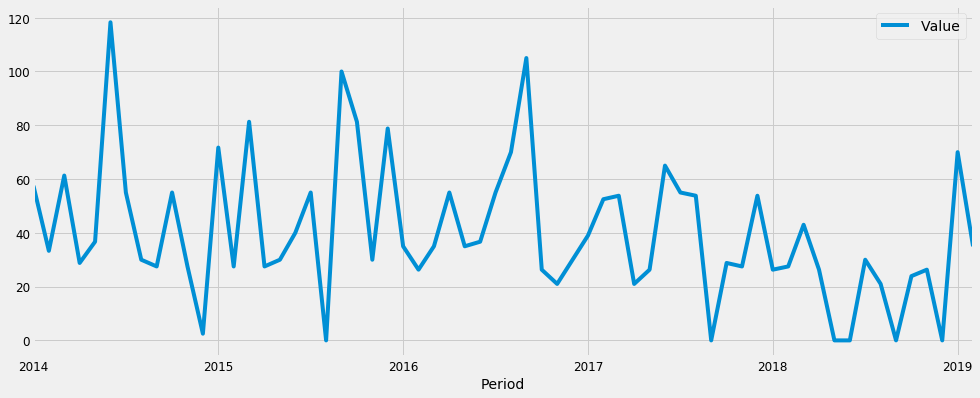

In [258]:
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

cols = ['Data', 'Organisation unit']
pesi_group.drop(cols, axis=1, inplace=True)

plt.clf()
pesi_group.plot(figsize=(15, 6))
plt.show()



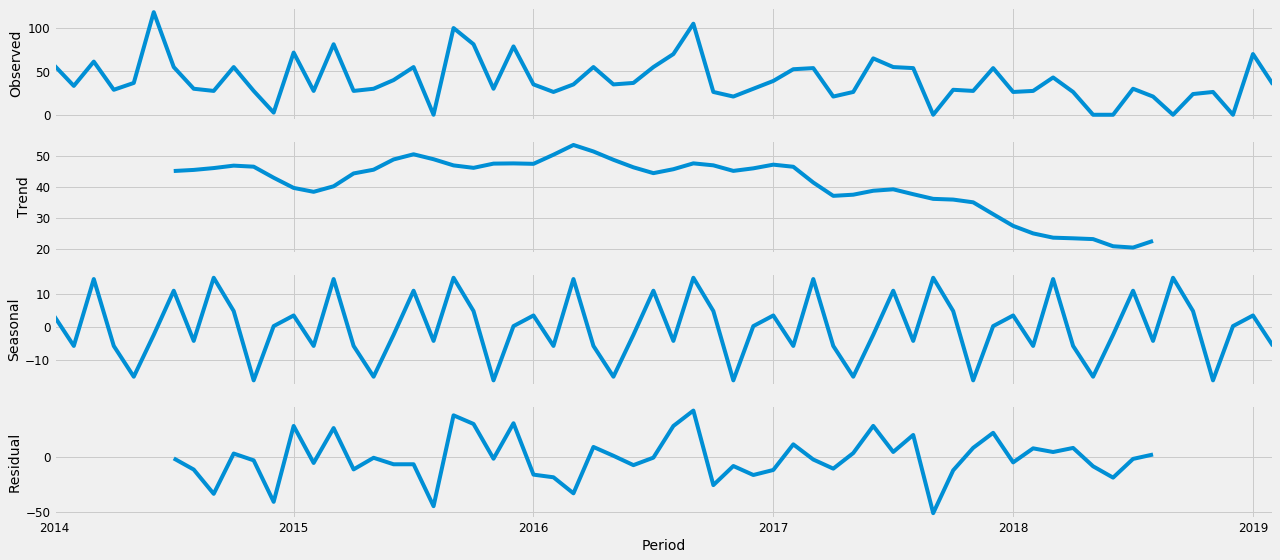

In [259]:

# Plot the time series features
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(pesi_group, model='additive')
fig = decomposition.plot()
plt.show()



In [260]:
# parameter Selection for our Wastage Rate ARIMA Time Series Model. 
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(pesi_group,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:646.0087374358588
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:500.30527036123163
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:490.59690567837265
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:359.1673431589165
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:489.5038790573098
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:471.7756253413595
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:372.2495220013074
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:361.1664491069994
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:614.3209186522218
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:482.20185779767087
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:483.5700899388562
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:351.44797860607076
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:490.9324278157795
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:464.85336093797235
ARIMA(0, 0, 1)x(1, 1, 0, 12)

In [261]:

# fitting the model

mod = sm.tsa.statespace.SARIMAX(pesi_group,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0250      0.259      0.097      0.923      -0.483       0.533
ma.L1         -0.9378      0.133     -7.036      0.000      -1.199      -0.677
ar.S.L12    9.533e-05      0.240      0.000      1.000      -0.470       0.470
ma.S.L12      -0.7474      0.581     -1.287      0.198      -1.886       0.391
sigma2       707.2850    319.844      2.211      0.027      80.403    1334.167


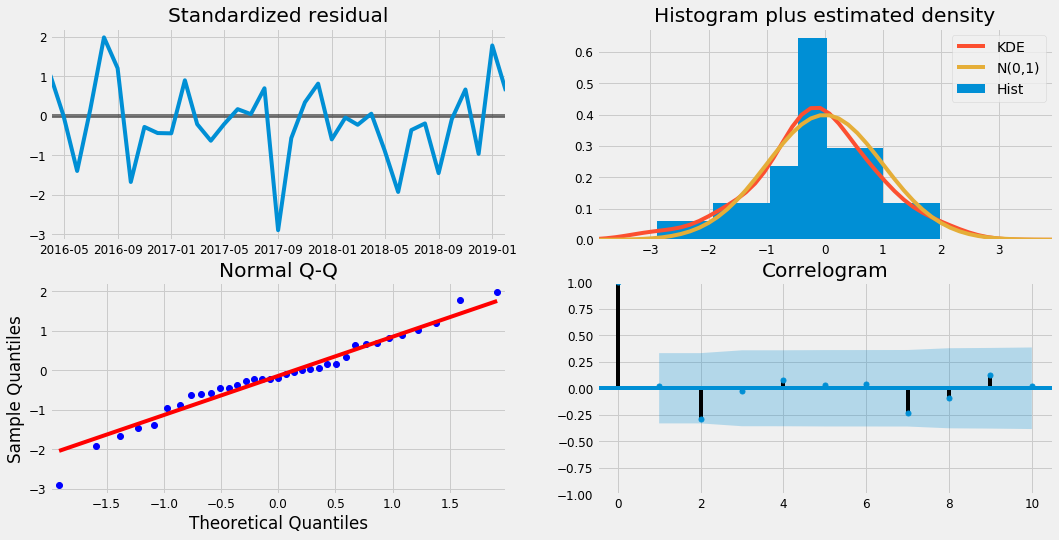

In [262]:
# investigate any unusual behaviour by running diagnostics

results.plot_diagnostics(figsize=(16, 8))
plt.show()



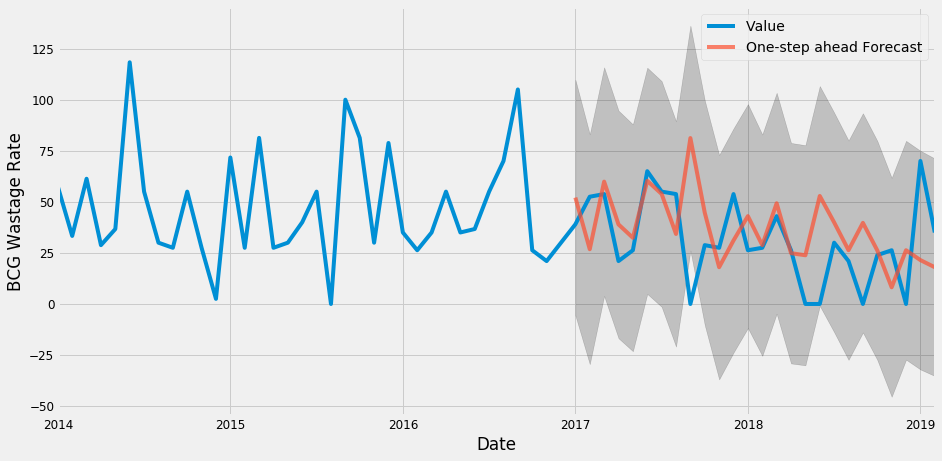

In [263]:
# validating forecast

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = pesi_group['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('BCG Wastage Rate')
plt.legend()
plt.show()



In [266]:
# Accuracy
import numpy as np
y_forecasted = pred.predicted_mean
y_truth = pesi_group['2017-01-01':]
product = (y_forecasted - y_truth).fillna(y_forecasted)

mse = (product ** 2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))



The Mean Squared Error of our forecasts is 2017-01-01 00:00:00    2713.05
2017-02-01 00:00:00     717.90
2017-03-01 00:00:00    3587.51
2017-04-01 00:00:00    1516.59
2017-05-01 00:00:00    1049.58
2017-06-01 00:00:00    3635.29
2017-07-01 00:00:00    2900.14
2017-08-01 00:00:00    1173.63
2017-09-01 00:00:00    6595.27
2017-10-01 00:00:00    1993.70
2017-11-01 00:00:00     323.61
2017-12-01 00:00:00     966.66
2018-01-01 00:00:00    1849.87
2018-02-01 00:00:00     828.54
2018-03-01 00:00:00    2430.75
2018-04-01 00:00:00     618.38
2018-05-01 00:00:00     568.78
2018-06-01 00:00:00    2794.70
2018-07-01 00:00:00    1593.97
2018-08-01 00:00:00     693.06
2018-09-01 00:00:00    1576.15
2018-10-01 00:00:00     688.91
2018-11-01 00:00:00      66.66
2018-12-01 00:00:00     692.14
2019-01-01 00:00:00     461.19
2019-02-01 00:00:00     323.41
Value                      NaN
dtype: float64
The Root Mean Squared Error of our forecasts is 2017-01-01 00:00:00    52.09
2017-02-01 00:00:00    26.79

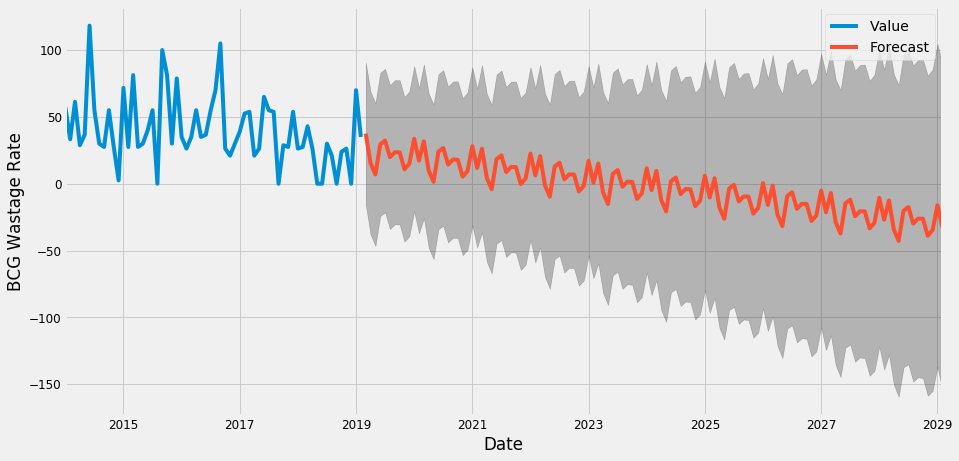

In [267]:
# Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=120)
pred_ci = pred_uc.conf_int()
ax = pesi_group.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('BCG Wastage Rate')
plt.legend()
plt.show()


